# Organization of this notebook

1 - Various imports that will be useful all along the notebook

2 - Objectives of the practical session

3 - The dataset

.... 3.1 - Creation of the dataset

.... 3.2 - Analysis of the dataset

......... 3.2.1 - Uniformity of choices

......... 3.2.2 - Regularity of the patterns

......... 3.2.3 - Regularity of the movements in the game interface

4 - A GRU for winning the game

.... 4.1 - Preparing the training and validation datasets

.... 4.2 - Formatting data for PyTorch

.... 4.3 - Instanciating the model

.... 4.4 - Training the model

.... 4.5 - Let's play!

.... 4.6 - Impact of the hyperparameters

5 - Exercise

# 1 - Various imports that will be useful all along the notebook

In [43]:
import IPython.display as display
import ipywidgets
import ipywidgets.widgets as widgets
import matplotlib.pyplot as pyplot
import statsmodels.graphics.tsaplots as tsaplots
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import pandas
import numpy
import random
import torch
import torch.nn as nn
import os
import os.path as path
import time

# 2 - Objectives of the practical session

In this session, we are going to train a GRU to beat you at Rock-Paper-Scissors-Lizard-Spock. If you are unfamiliar with the game, here is a short extract from the Big Bang Theory series which presents its rules:

In [44]:
display.IFrame(width="975", height="550", src="https://www.youtube.com/embed/x5Q6-wMx-K8?rel=0&amp;controls=0&amp;showinfo=0")

As this may be hard to remember the first couple of times, here is a diagram summing up the rules. An arrow from A to B means that A beats B:

In [45]:
display.Image(width=975, url="https://res.cloudinary.com/teepublic/image/private/s--EL3WFTcn--/t_Resized%20Artwork/c_fit,g_north_west,h_954,w_954/co_ffffff,e_outline:48/co_ffffff,e_outline:inner_fill:48/co_ffffff,e_outline:48/co_ffffff,e_outline:inner_fill:48/co_bbbbbb,e_outline:3:1000/c_mpad,g_center,h_1260,w_1260/b_rgb:eeeeee/c_limit,f_jpg,h_630,q_90,w_630/v1547912246/production/designs/4037632_0.jpg")

Finally, let us sum up this as a Python code, that we will use in this practical session. First, let's define a list of possible moves:

In [46]:
"""
Constant with the possible moves of the game.
"""
POSSIBLE_MOVES = ["Rock", "Paper", "Scissors", "Lizard", "Spock"]

Then, in order to print the results of the various matches we will play, here is a simple Python function that takes two decisions as an input, and returns a string describing who wins:

In [47]:
"""
This function encodes the diagram above.
Arguments:
----------
  * player: Decision of the player, to take from the values in POSSIBLE_MOVES.
  * opponent: Decision of the opponent, to take from the values in POSSIBLE_MOVES.
Returns:
--------
  * result: 0 if the player loses, 1 for a draw, 2 is when player wins.
  * text_result: Textual representation of the result.
"""
def check_who_wins (player, opponent) :
    
    # Matrix with indices 0-4 corresponding with possible moves in the order of POSSIBLE_MOVES
    result_to_string = {0: "You lose", 1: "Draw", 2: "You win"}
    matrix_wins = numpy.array([[1, 0, 2, 2, 0],
                               [2, 1, 0, 0, 2],
                               [0, 2, 1, 2, 0],
                               [0, 2, 0, 1, 2],
                               [2, 0, 2, 0, 1]])
    
    # We check who wins
    result = matrix_wins[POSSIBLE_MOVES.index(player), POSSIBLE_MOVES.index(opponent)]
    text_result = result_to_string[result]
    
    return result, text_result

Let's check if everything seems to work fine:

In [48]:
# Print all possible combinations
for player in POSSIBLE_MOVES :
    for opponent in POSSIBLE_MOVES :
        result, text_result = check_who_wins(player, opponent)
        print("Player:", player, "-- Opponent:", opponent, "--", text_result)

Player: Rock -- Opponent: Rock -- Draw
Player: Rock -- Opponent: Paper -- You lose
Player: Rock -- Opponent: Scissors -- You win
Player: Rock -- Opponent: Lizard -- You win
Player: Rock -- Opponent: Spock -- You lose
Player: Paper -- Opponent: Rock -- You win
Player: Paper -- Opponent: Paper -- Draw
Player: Paper -- Opponent: Scissors -- You lose
Player: Paper -- Opponent: Lizard -- You lose
Player: Paper -- Opponent: Spock -- You win
Player: Scissors -- Opponent: Rock -- You lose
Player: Scissors -- Opponent: Paper -- You win
Player: Scissors -- Opponent: Scissors -- Draw
Player: Scissors -- Opponent: Lizard -- You win
Player: Scissors -- Opponent: Spock -- You lose
Player: Lizard -- Opponent: Rock -- You lose
Player: Lizard -- Opponent: Paper -- You win
Player: Lizard -- Opponent: Scissors -- You lose
Player: Lizard -- Opponent: Lizard -- Draw
Player: Lizard -- Opponent: Spock -- You win
Player: Spock -- Opponent: Rock -- You win
Player: Spock -- Opponent: Paper -- You lose
Player: S

# 3 - The dataset

## 3.1 - Creation of the dataset

Now that you have understood the game we are going to play, well, let's play a bit! The following cell defines a graphical interface to play the game:

In [49]:
"""
This function creates a GUI to play the game of Rock-Paper-Scissors-Lizard-Spock.
Arguments:
----------
  * callback_function: Function that is called everytime a button is pressed.
  * initial_text_before: Text to print above the buttons at the beginning.
  * initial_text_after: Text to print below the buttons at the beginning.
Returns:
--------
  * text_before: Updatable text area above the buttons.
  * text_after: Updatable text area below the buttons.
"""
def show_interface (callback_function, initial_text_before, initial_text_after) :
    
    # Buttons (one for each entry in POSSIBLE_MOVES)
    buttons = [widgets.Button(description=move) for move in POSSIBLE_MOVES]
    buttons_line = ipywidgets.HBox(buttons)
    for button in buttons :
        button.on_click(callback)
    
    # Show them
    # If you get some boring warnings, try the following 2 commands:
    # pip3 install widgetsnbextension
    # jupyter nbextension enable --py widgetsnbextension
    text_before = display.display(initial_text_before, display_id=True)
    display.display(buttons_line)
    text_after = display.display(initial_text_after, display_id=True)
    
    return text_before, text_after

The following code will instanciate a game interface, and ask you to play several games of Rock-Paper-Scissors-Lizard-Spock. Your decisions will be recorded (in a file in case your kernel crashes somehow), and will later be used to train the GRU.

This part may take some time, so don't overthink it and be as intuitive as possible. Even if you think you play randomly, you will unconsciously repeat some patterns over time that the GRU will learn and exploit:

In [50]:
"""
Constant with the name of the file where to save/load the decisions.
"""
DATASET_FILE = "rpsls_dataset.csv"

In [51]:
"""
Constant with the expected size for the dataset we want to create.
If the file already contains more than this quantity, we will use all of the file contents.
"""
EXPECTED_DATASET_SIZE = 500

In [52]:
# First, let's load existing games
dataset_file = open(DATASET_FILE, "a+")
dataset_file.seek(0)
dataset = [entry for entry in dataset_file.readline().replace(" ", "").replace("\n", "").split(";") if entry != ""]

In [53]:
"""
Callback function to give to the show_interface function.
Arguments:
----------
  * button: Button which is clicked, with choice accessible through button.description.
Returns:
--------
  * None.
"""
def callback (button) :

    # Save the choice of the player
    if len(dataset) < EXPECTED_DATASET_SIZE :
        if len(dataset) > 0 :
            dataset_file.write(";")
        dataset_file.write(button.description)
        dataset_file.flush()
        dataset.append(button.description)
    
    # show what a random player would have played
    opponent = random.choice(POSSIBLE_MOVES)
    result, text_result = check_who_wins(button.description, opponent)
    text_before.update("[" + str(len(dataset)) + " / " + str(EXPECTED_DATASET_SIZE) + "] -- Choose one:")
    text_after.update("Player: " + button.description + " -- Opponent: " + opponent + " -- " + text_result)

In [54]:
# Interface
text_before, text_after = show_interface(callback, "[" + str(len(dataset)) + " / " + str(EXPECTED_DATASET_SIZE) + "] -- Choose one:", "")

'[500 / 500] -- Choose one:'

''

## 3.2 - Analysis of the dataset

Let's have a look at what you played during dataset generation. Through a few quick analyzes, we will try to see if you are predictable enough for a neural network to anticipate your behavior.

### 3.2.1 - Uniformity of choices

First, let's see if you made some uniform choices:

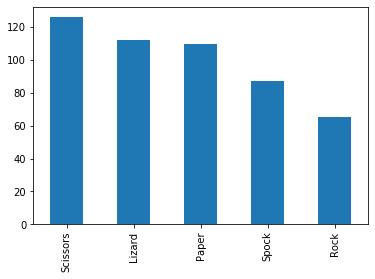

In [55]:
# Histogram of the choices made
pandas.Series(dataset).value_counts().plot(kind="bar")

### 3.2.2 - Regularity of the patterns

Another interesting aspect we should evaluate is whether you tend to regularly repeat some patterns in your play style. Let's compute a pseudo-autocorrelation of the dataset, seen as a time series.

Normally, to compute autocorrelation of a time series, we shift it by a lag L, and compute the correlation between the lagged series and the original one. Since it does not directly make sense for series of words, we proceed by doing the same, with the difference that we replace autocorrelation with a simple count of the words that remain the same when lagged:

In [56]:
"""
Function to compute a pseudo-measure of autocorrelation.
Arguments:
----------
  * series: List of words for which we want to compute the pseudo-autocorrelation.
  * lag: Shift to apply to the list elements to compute pseudo-autocorrelation.
Returns:
--------
  * ratio: Ratio of indices that have the same word in the lagged and non-lagged series.
"""
def pseudo_autocorrelation (series, lag) :
    
    # We shift the series by the lag
    lagged_series = numpy.roll(series, lag)
    
    # We count the number of identical entries and return a percentage
    count = numpy.sum(numpy.array(series) == lagged_series)
    ratio = count / len(series)
    
    return ratio

Let's compute this quantity for all possible lags on your decisions:

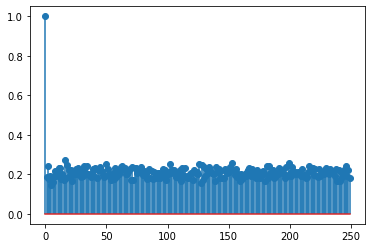

In [15]:
# Pseudo-autocorrelation of time series
lags = range(round(len(dataset) / 2))
measures = [pseudo_autocorrelation(dataset, lag) for lag in lags]

# Plot
pyplot.stem(lags, measures, use_line_collection=True)
pyplot.show()

Obviously, lag 0 is not very informative. Let's remove it:

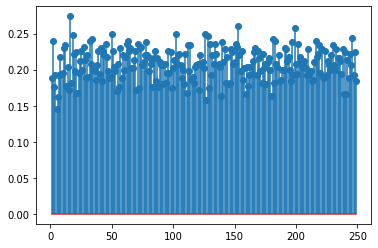

In [16]:
# Plot
pyplot.stem(lags[1:], measures[1:], use_line_collection=True)
pyplot.show()

Random behavior should lead to a mean around 1/len(POSSIBLE_MOVES). If you see a spike somewhere ar lag L, it indicates that you tend to repeat the same sequence of actions every L turns.

To conclude with this analysis, let's focus more on small lag values, as it is more probable that you have short-time regularities (let's say Rock-Paper-Scissors-Rock-Paper-Scissors-Rock-Paper-Scissors-...) than long ones:

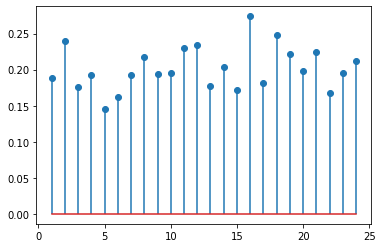

In [17]:
# Plot
pyplot.stem(lags[1:25], measures[1:25], use_line_collection=True)
pyplot.show()

### 3.2.3 - Regularity of the movements in the game interface

It is quite possible that the previous analysis didn't show anything significant for you, since you may not have been regularly repeating sequences of choices.

Now, let's try to simply replace Rock-Paper-Scissors-Lizard-Spock in the dataset with their indices in POSSIBLE_MOVES, and compute the autocorrelation of the obtained series. At first sight, this should not make a lot of sense to do so, as different assignments of indices should lead to different results.

However, the order in which choices are organized in POSSIBLE_MOVES is the same as the one in which the associated buttons are presented in the game interface. Therefore, an increase in index corresponds to choosing a button on the right of the previous one, and a decrease corresponds to choosing a button on the left of the previous one. Therefore, if you measure a significant autocorrelation, you may be prone to regularities in your choices based on how the interface is organized.

This time, let us analyze autocorrelation using a correlogram:

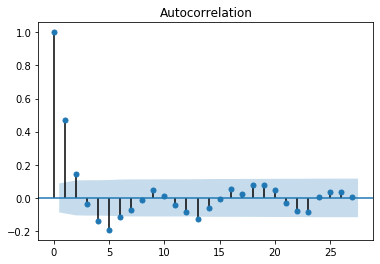

In [18]:
# We replace moves with the indices
dataset_as_numbers = [POSSIBLE_MOVES.index(move) for move in dataset]

# Plot autocorrelation
tsaplots.plot_acf(numpy.array(dataset_as_numbers))
pyplot.show()

In this plot, the blue area shows the 95% confidence threshold. If you see some values go out of the area, you most certainly repeat patterns in your movements.

Finally, we may be also interested in the partial autocorrelations. In brief, partial autocorrelation at lag L is the correlation that results after removing the effect of any correlations due to the terms at shorter lags [1].

[1] P.S.P. Cowpertwait & A.V. Metcalfe -- Introductory Time Series with R (2009).

We can compute it as follows:

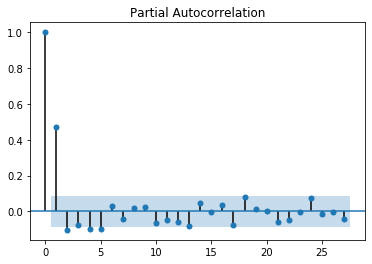

In [19]:
# Plot partial autocorrelations
tsaplots.plot_pacf(numpy.array(dataset_as_numbers))
pyplot.show()

Let's see what this would look like in a baseline situation, in which we alternate between buttons on the left and on the right of the previous one:

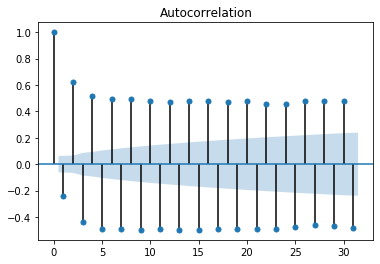

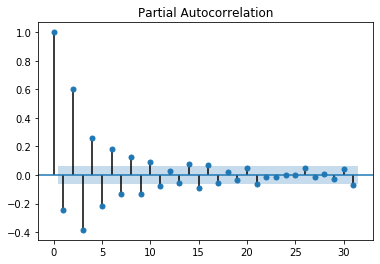

In [20]:
# Create dataset
dataset_left_right = [0]
go_right = True
for i in range(1000) :
    previous = dataset_left_right[-1]
    if go_right :
        choices = range(previous+1, len(POSSIBLE_MOVES))
    else :
        choices = range(0, previous)
    dataset_left_right.append(random.choice(choices))
    go_right = not go_right

# Plot autocorrelation
tsaplots.plot_acf(numpy.array(dataset_left_right))
pyplot.show()

# Plot partial autocorrelations
tsaplots.plot_pacf(numpy.array(dataset_left_right))
pyplot.show()

Clearly, there is a correlation for even lag values, and an anticorrelation for odd ones.

If you want to know a bit more about correlograms, here is a short online resource giving hints on how to interprete them: http://itfeature.com/time-series-analysis-and-forecasting/correlogram

# 4 - A GRU for winning the game

## 4.1 - Preparing the training and validation datasets

Before we train the model with data, we need to format them so that they can be understood by the network. Let's use one-hot encoding. Since there are 5 possible choices in the game, we will have a 5-dimensional input vector, in which only one entry is equal to 1 at a time.

In [21]:
# Strings to one-hot
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(numpy.array(POSSIBLE_MOVES).reshape(-1, 1))

# Print encoding
print("Encoding:")
for i in range(len(POSSIBLE_MOVES)) :
    print(POSSIBLE_MOVES[i], "->", onehot_encoded[i])

# Encode dataset
encoded_dataset = onehot_encoder.transform(numpy.array(dataset).reshape(len(dataset), 1))

# Print a few examples from the dataset
print("\nExamples:")
NB_PRINTS = 10
for i in range(NB_PRINTS) :
    print(dataset[i], "->", encoded_dataset[i])

Encoding:
Rock -> [0. 0. 1. 0. 0.]
Paper -> [0. 1. 0. 0. 0.]
Scissors -> [0. 0. 0. 1. 0.]
Lizard -> [1. 0. 0. 0. 0.]
Spock -> [0. 0. 0. 0. 1.]

Examples:
Paper -> [0. 1. 0. 0. 0.]
Scissors -> [0. 0. 0. 1. 0.]
Spock -> [0. 0. 0. 0. 1.]
Scissors -> [0. 0. 0. 1. 0.]
Rock -> [0. 0. 1. 0. 0.]
Paper -> [0. 1. 0. 0. 0.]
Scissors -> [0. 0. 0. 1. 0.]
Lizard -> [1. 0. 0. 0. 0.]
Scissors -> [0. 0. 0. 1. 0.]
Paper -> [0. 1. 0. 0. 0.]


Now, let's separate the dataset into a train set and a validation set:

In [22]:
"""
Constant indicating the proportion of the dataset to use as training set.
"""
TRAINING_SET_RATIO = 0.9

In [23]:
# Let's split the dataset
train_X = encoded_dataset[: int(TRAINING_SET_RATIO * encoded_dataset.shape[0])][:-1]
train_Y = encoded_dataset[: int(TRAINING_SET_RATIO * encoded_dataset.shape[0])][1:]
val_X = encoded_dataset[int(TRAINING_SET_RATIO * encoded_dataset.shape[0]) :][:-1]
val_Y = encoded_dataset[int(TRAINING_SET_RATIO * encoded_dataset.shape[0]) :][1:]

# Info
print("train_X", train_X.shape)
print("train_Y", train_Y.shape)
print("val_X", val_X.shape)
print("val_Y", val_Y.shape)

train_X (449, 5)
train_Y (449, 5)
val_X (49, 5)
val_Y (49, 5)


## 4.2 - Formatting data for PyTorch

Ok, so let's start working with GRUs now. As for more standard neural networks, we first need to design the model we are going to train. To do so, we will use the PyTorch library, which is one of the gold standards in the deep learning community.

First, let's indicate PyTorch that it should use your GPU if you have one available:

In [24]:
# Check if GPU is available
is_cuda = torch.cuda.is_available()

# Select it as default, or CPU otherwise
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

PyTorch requires a particular object for the input data. The following code transforms the numpy arrays into these objects. Note that there is now a third dimension in the tensor (the first one), which corresponds to the batch size. Here, we are just considering one time series in our batch, so we do not really care about it:

In [25]:
# Transform into PyTorch tensor
train_X = torch.from_numpy(train_X.reshape(1, *train_X.shape)).to(device).float()
train_Y = torch.from_numpy(train_Y.reshape(1, *train_Y.shape)).to(device).float()
val_X = torch.from_numpy(val_X.reshape(1, *val_X.shape)).to(device).float()
val_Y = torch.from_numpy(val_Y.reshape(1, *val_Y.shape)).to(device).float()

# Info
print("train_X", train_X.shape)
print("train_Y", train_Y.shape)
print("val_X", val_X.shape)
print("val_Y", val_Y.shape)

train_X torch.Size([1, 449, 5])
train_Y torch.Size([1, 449, 5])
val_X torch.Size([1, 49, 5])
val_Y torch.Size([1, 49, 5])


## 4.3 - Instanciating the model

Let's build the GRU architecture. Contrary to Tensorflow (another gold standard library in deep learning) which requires us to detail all the weight matrices and how they interact, PyTorch provides a pretty simple way for building GRUs:

In [26]:
"""
GRU class, which extends the base PyTorch class Module.
"""
class GRU (nn.Module) :
    
    """
    Class constructor.
    This method is called when you instanciate an object of the class.
    Arguments:
    ----------
      * input_dimension: Size of the input data.
      * hidden_dimension: Size of the hidden vector.
      * output_dimension: Size of the output data.
      * nb_layers: Number of consecutive GRU units (cells) before looping (not useful here).
      * dropout_probability: Probability of an edge in the network to be forced to 0 (not useful here, as we just have one layer).
    Returns:
    --------
      * None.
    """
    def __init__ (self, input_dimension, hidden_dimension, output_dimension, nb_layers=1, dropout_probability=0.0) :
        
        # Call parent's class constructor before anything else
        super(GRU, self).__init__()
        
        # Save arguments
        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.output_dimension = output_dimension
        self.nb_layers = nb_layers
        self.dropout_probability = dropout_probability
        
        # Add one fully connected layer (+ ReLU nonlinearity) after the hidden layer to get output
        self.fc = nn.Linear(hidden_dimension, output_dimension)
        self.relu = nn.ReLU()
        
        # Instanciate a GRU
        self.gru = nn.GRU(input_dimension, hidden_dimension, nb_layers, batch_first=True, dropout=dropout_probability)
        
    """
    Method to describe how we perform a forward pass.
    Arguments:
    ----------
      * input_t: Input data at time t.
      * hidden_tm1: Hidden vector output by GRU at time t-1.
    Returns:
    --------
      * output_t: Prediction of the network at time t.
    """
    def forward (self, input_t, hidden_tm1):
        
        # Go through the GRU and compute output
        output_t, hidden_t = self.gru(input_t, hidden_tm1)
        output_t = self.fc(self.relu(output_t))
        
        return output_t
    
    """
    Method to reset the hidden layer between epochs when training, or between tests.
    Arguments:
    ----------
      * batch_size: Number of time series to process at the same time (not useful here).
      * hidden_tm1: Hidden vector output by GRU at time t-1.
    Returns:
    --------
      * hidden: Zero hidden state.
    """
    def reset_hidden (self, batch_size=1) :
        
        # Create a hidden state full of zeros
        weight = next(self.parameters()).data
        hidden = weight.new(self.nb_layers, batch_size, self.hidden_dimension).zero_()
        
        return hidden

Now that the model is described (we basically just encapsulated the PyTorch default implementation of GRUs), let's instanciate it:

In [27]:
"""
Constant to choose a hidden layer size.
This is an arbitrary choice, we will try to study its impact at the end of this notebook.
"""
HIDDEN_DIMENSION = 15

In [28]:
# Model dimensions
input_dimension = train_X.shape[2]
output_dimension = train_X.shape[2]

# Instanciate model
model = GRU(input_dimension, HIDDEN_DIMENSION, output_dimension).to(device)

## 4.4 - Training the model

Let's train our network:

In [29]:
"""
Constant to choose how many epochs we will train our network for.
The higher you choose it, the longer the network will train.
"""
EPOCHS = 100

In [30]:
"""
Constant to set how fast the network will learn.
This controls the gradient step when updating weights.
"""
LEARNING_RATE = 0.01

In [31]:
"""
Function to plot a figure indicating the current training situation.
Arguments:
----------
  * epochs: X axis of the figure.
  * train_losses: All obtained losses on the training set.
  * val_losses: All obtained losses on the validation set.
Returns:
--------
  * None.
"""
def plot_current_losses (epochs, train_losses, val_losses) :
    
    # Plot losses as a function of epochs
    pyplot.plot(epochs, train_losses, "-b", label="Train loss")
    pyplot.plot(epochs, val_losses, "-r", label="Validation loss")
    pyplot.legend(loc=0)
    pyplot.xlabel("Epoch")
    pyplot.ylabel("Loss")
    pyplot.show()

In [32]:
"""
We train the network in a function, because we will do it again at the end of the notebook.
Arguments:
----------
  * model: Model to train.
  * train_X: Training dataset.
  * train_Y: Training labels.
  * val_X: Validation dataset.
  * val_Y: Validation labels.
  * learning_rate: Controls speed at which the network learns.
  * nb_epochs: Number of epochs of training.
  * show_plots: Flag to indicate if we regularly plot the loss.
  * save_model_to: Directory where to save the model at each epoch.
Returns:
--------
  * train_losses: All obtained losses on the training set.
  * val_losses: All obtained losses on the validation set.
"""
def train (hidden_dimension, train_X, train_Y, val_X, val_Y, learning_rate, nb_epochs, show_plots=True, save_model_to=None) :
    
    # Mean square error loss
    loss_function = nn.MSELoss()
    
    # Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # We enter in train mode
    model.train()
    
    # Let's go
    train_losses = []
    val_losses = []
    for epoch in range(1, nb_epochs + 1) :
        
        # Reset hidden state vector and gradients
        zero_hidden = model.reset_hidden().to(device)
        model.zero_grad()
        
        # Forward pass, compute loss, retropropagate gradients, update weights
        output = model(train_X, zero_hidden.data)
        train_loss = loss_function(output, train_Y)
        train_loss.backward()
        optimizer.step()
        
        # Let's see how it performs on validation set
        # Same steps as above, but we do not compute gradients or update weights
        zero_hidden = model.reset_hidden().to(device)
        output = model(val_X, zero_hidden.data)
        val_loss = loss_function(output, val_Y)
        
        # Save the model if asked
        if save_model_to is not None :
            if not path.exists(save_model_to) :
                os.makedirs(save_model_to)
            torch.save(model.state_dict(), save_model_to + path.sep + str(epoch))
        
        # Plot current state
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        if show_plots and (epoch == 1 or epoch % 10 == 0) :
            display.clear_output()
            plot_current_losses(range(1, epoch + 1), train_losses, val_losses)
            print("Epoch:", epoch, "-- Training loss:", train_loss.item(), "-- Validation loss:", val_loss.item())
    
    return train_losses, val_losses

In [33]:
"""
Constant specifying where we will save the trained models at each epoch.
"""
SAVE_MODEL_TO = "trained_models"

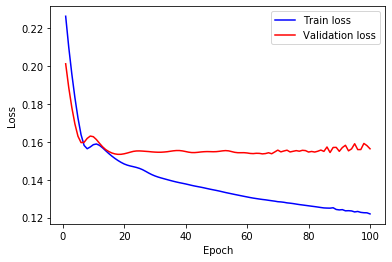

Epoch: 100 -- Training loss: 0.12193518131971359 -- Validation loss: 0.1563185155391693


In [34]:
# We train the model
train_losses, val_losses = train(model, train_X, train_Y, val_X, val_Y, LEARNING_RATE, EPOCHS, save_model_to=SAVE_MODEL_TO)

You should probably see that the validation loss starts to increase after some time. This is characteristic of overfitting. Indeed, the training loss continues to decrease because the network starts to learn it by heart. The best thing to do here is therefore to stop learning when this phenomenon arises.

In the call to function train() above, we have set the save_model_to argument to a directory. This has caused the function to save the model to that location, at each epoch. Let's load the best model we obtained:

In [35]:
# Find minimum validation loss
best_epoch = 1 + numpy.argmin(val_losses)

# Load associated model and switch to usage mode
model.load_state_dict(torch.load(SAVE_MODEL_TO + path.sep + str(best_epoch)))
model.eval()

GRU(
  (fc): Linear(in_features=15, out_features=5, bias=True)
  (relu): ReLU()
  (gru): GRU(5, 15, batch_first=True)
)

## 4.5 - Let's play!

Contrary to when we generated the dataset earlier, we will now play against an opponent that tries to predict your moves. Let's see if you were predictable enough so that the GRU can beat you:

In [36]:
"""
Function to ask the model to predict player's decision and return a move that beats it.
Arguments:
----------
  * model: Trained model used for making decisions.
  * player_previous_move: Move that was played by the player the turn before.
Returns:
--------
  * move: Decision of the GRU.
  * prediction_vector: Output of the GRU.
  * prediction: Prediction for the player's move.
"""
def determine_move (model, player_previous_move) :
    
    # Encode player's previous move
    onehot_previous = onehot_encoder.transform(numpy.array([player_previous_move]).reshape(-1, 1))
    encoded_previous = torch.from_numpy(onehot_previous.reshape(1, *onehot_previous.shape)).to(device).float()
    
    # Predict player's decision
    zero_hidden = model.reset_hidden().to(device)
    prediction_vector = model(encoded_previous, zero_hidden.data).detach().numpy()[0, 0]
    onehot_prediction = numpy.array(prediction_vector == max(prediction_vector), dtype=float)
    prediction = onehot_encoder.inverse_transform([onehot_prediction])[0, 0]
    
    # Determine decision
    winning_moves = {"Rock": "Paper",
                     "Paper": "Scissors",
                     "Scissors": "Spock",
                     "Lizard": "Rock",
                     "Spock": "Lizard"}
    move = winning_moves[prediction]
    
    return move, prediction_vector, prediction

In [37]:
# We store the player's previous choice and results (lose/draw/win)
player_previous_move = None
game_results = [0, 0, 0]

# Callback function called when a button is clicked
def callback (button) :
    
    # First time, we play at random
    # Then, get network prediction
    global player_previous_move
    if player_previous_move is None :
        opponent = random.choice(POSSIBLE_MOVES)
        details = "Played randomly"
    else :
        opponent, prediction_vector, prediction = determine_move(model, player_previous_move)
        sorted_predictions = prediction_vector[onehot_encoded.argmax(axis=0)]
        details = str([POSSIBLE_MOVES[i][:2] + ": " + str(round(sorted_predictions[i], 2)) for i in range(len(POSSIBLE_MOVES))])
        
    # Update results and previous move
    global game_results
    result, text_result = check_who_wins(button.description, opponent)
    game_results[result] += 1
    player_previous_move = button.description
    
    # Show results
    text_before.update("[L: " + str(game_results[0]) + " / D: " + str(game_results[1]) + " / W: " + str(game_results[2]) + "] -- Choose one:")
    text_after.update("Player: " + button.description + " -- Opponent: " + opponent + " (" + details + ") -- " + text_result)

    
# Interface
text_before, text_after = show_interface(callback, "[L: " + str(game_results[0]) + " / D: " + str(game_results[1]) + " / W: " + str(game_results[2]) + "] -- Choose one:", "")

'[L: 0 / D: 0 / W: 0] -- Choose one:'

''

So, how predictable are you? :)

## 4.6 - Impact of the hyperparameters

In neural networks, we call hyperparameters the various quantities we (more or less) arbitrarily tune when designing the model architecture. As you may be aware of, the choice of these hyperparameters has a direct impact on the network performance.

In order to illustrate this, we will evaluate the best validation loss we can achieve, as a function of the size of the hidden vector in the GRU:

In [38]:
"""
Constant defining for which values of hidden dimension we compute the loss.
"""
HIDDEN_DIMENSIONS = range(1, 51)

In [39]:
# Let's train a model for each hidden dimension
all_val_losses = []
all_times = []
for hidden_dimension in HIDDEN_DIMENSIONS :
    
    # Info
    print("Training a network for hidden dimension", hidden_dimension)
    start_time = time.time()
    
    # Train
    model = GRU(input_dimension, hidden_dimension, output_dimension).to(device)
    train_losses, val_losses = train(model, train_X, train_Y, val_X, val_Y, LEARNING_RATE, EPOCHS, show_plots=False)
    all_val_losses.append(min(val_losses))
    all_times.append(time.time() - start_time)
    
    # Info
    print(".... Completed in", all_times[-1], "seconds")
    print(".... Min validation loss found: ", all_val_losses[-1])

Training a network for hidden dimension 1
.... Completed in 8.22016167640686 seconds
.... Min validation loss found:  0.1728096902370453
Training a network for hidden dimension 2
.... Completed in 8.962529420852661 seconds
.... Min validation loss found:  0.15016792714595795
Training a network for hidden dimension 3
.... Completed in 10.039695262908936 seconds
.... Min validation loss found:  0.14868122339248657
Training a network for hidden dimension 4
.... Completed in 8.743772983551025 seconds
.... Min validation loss found:  0.15448610484600067
Training a network for hidden dimension 5
.... Completed in 9.262523412704468 seconds
.... Min validation loss found:  0.15756337344646454
Training a network for hidden dimension 6
.... Completed in 9.217220306396484 seconds
.... Min validation loss found:  0.149107426404953
Training a network for hidden dimension 7
.... Completed in 10.63045883178711 seconds
.... Min validation loss found:  0.15399764478206635
Training a network for hidden 

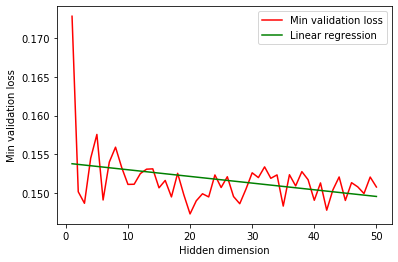

In [40]:
# Compute linear regression for losses
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(numpy.array(HIDDEN_DIMENSIONS).reshape(-1, 1), all_val_losses)
regression = linear_regressor.predict(numpy.array(HIDDEN_DIMENSIONS).reshape(-1, 1))

# Plot min validation loss as a function of hidden dimension
pyplot.plot(HIDDEN_DIMENSIONS, all_val_losses, "-r", label="Min validation loss")
pyplot.plot(HIDDEN_DIMENSIONS, regression, "-g", label="Linear regression")
pyplot.legend(loc=0)
pyplot.xlabel("Hidden dimension")
pyplot.ylabel("Min validation loss")
pyplot.show()

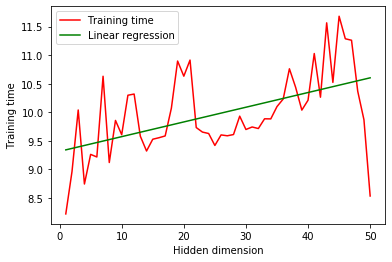

In [41]:
# Compute linear regression for times
linear_regressor.fit(numpy.array(HIDDEN_DIMENSIONS).reshape(-1, 1), all_times)
regression = linear_regressor.predict(numpy.array(HIDDEN_DIMENSIONS).reshape(-1, 1))

# Plot min validation loss as a function of hidden dimension
pyplot.plot(HIDDEN_DIMENSIONS, all_times, "-r", label="Training time")
pyplot.plot(HIDDEN_DIMENSIONS, regression, "-g", label="Linear regression")
pyplot.legend(loc=0)
pyplot.xlabel("Hidden dimension")
pyplot.ylabel("Training time")
pyplot.show()

# 5 - Exercise

Now is your turn to work! Consider again what we did before, and try to build a GRU that predicts the decisions of an opponent that plays in a more predictible way.

Along with this notebook is provided a file called ordered_dataset.csv, describing a player whose decisions are always Rock-Paper-Scissors-Lizard-Spock-Rock-Paper-Scissors-Lizard-Spock-... You should be able to reach a near 100% win rate.